In [1]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

2025-02-16 17:40:56.849599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 17:40:56.861306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 17:40:56.877070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 17:40:56.877121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 17:40:56.887599: I tensorflow/core/platform/cpu_feature_gua

In [2]:
from joblib import load
emb_matrix=load('Embeddings/Embedding Matrix.joblib')
emb_matrix.shape

(400001, 50)

In [3]:
def model(emb_matrix):
    sentence_indices = Input(shape=(510,),dtype='int32')

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(emb_matrix.shape[0],emb_matrix.shape[1],trainable=False,mask_zero=True)
   
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    X = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128,return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    #X = Dropout(rate = config['last dropout rate'] )(X) 
    # Propagate X through a Dense layer with 5 units
    X = Dense(1)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
    
    
    
    return model


In [4]:
model=model(emb_matrix)

2025-02-16 17:40:58.680380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-16 17:40:58.716566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-16 17:40:58.716612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-16 17:40:58.720063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-16 17:40:58.720108: I external/local_xla/xla/stream_executor

In [5]:
model.compile(
        optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00280740528198314),
        loss='binary_crossentropy',
        metrics=['accuracy','binary_crossentropy']
    )

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 510)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 510, 50)   │ 20,000,050 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 510)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     91,648 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,091,827 (76.64 MB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [7]:
def loadDataset():
    dfTrain=pd.read_csv('Data/train.csv')
    dfDev=pd.read_csv('Data/dev.csv')
    X_train=dfTrain['padded_indices'].apply(eval).tolist()
    X_train=np.array(X_train, dtype=np.int32)
    Y_train = np.array(dfTrain['label'], dtype=np.int32).reshape(-1,1)

    X_dev=dfDev['padded_indices'].apply(eval).tolist()
    X_dev=np.array(X_dev, dtype=np.int32)
    Y_dev = np.array(dfDev['label'], dtype=np.int32).reshape(-1,1)

    return X_train,Y_train,X_dev,Y_dev

In [8]:
import pandas as pd
X_train,Y_train,X_dev,Y_dev=loadDataset()

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (change to 'val_accuracy' if needed)
    mode='min',  # 'min' because we want to minimize loss
    patience=5,  # Number of epochs to wait before stopping (adjust as needed)
    restore_best_weights=True,  # Restore best weights after stopping
    verbose=1
)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=10,  # Adjust as needed
    validation_data=(X_dev, Y_dev),
    callbacks=[early_stopping_callback]  # Use EarlyStopping
)

Epoch 1/10


2025-02-16 17:41:13.805964: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


885/885 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.8062 - binary_crossentropy: 0.4155 - loss: 0.4155 - val_accuracy: 0.9202 - val_binary_crossentropy: 0.1978 - val_loss: 0.1978
Epoch 2/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.9202 - binary_crossentropy: 0.1890 - loss: 0.1890 - val_accuracy: 0.9214 - val_binary_crossentropy: 0.1880 - val_loss: 0.1880
Epoch 3/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9455 - binary_crossentropy: 0.1339 - loss: 0.1339 - val_accuracy: 0.9456 - val_binary_crossentropy: 0.1430 - val_loss: 0.1430
Epoch 4/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9633 - binary_crossentropy: 0.0953 - loss: 0.0953 - val_accuracy: 0.9378 - val_binary_crossentropy: 0.1692 - val_loss: 0.1692
Epoch 5/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9728 - binary_crossentropy: 0.0727 - loss: 0.0727 - val_accuracy: 0.9181 - val_binary_crossentropy: 0.2031 - val_loss: 0.2031
Epoch 6/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 2

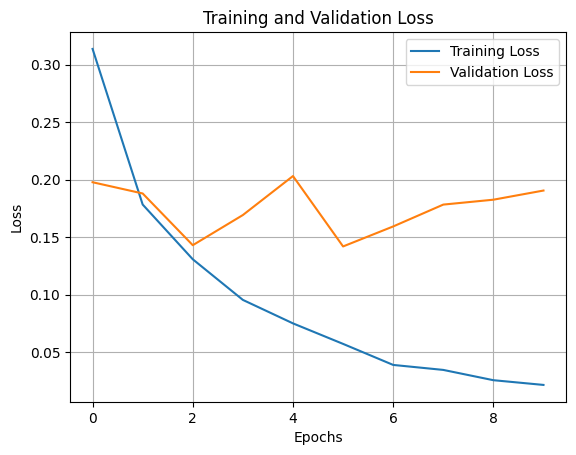

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


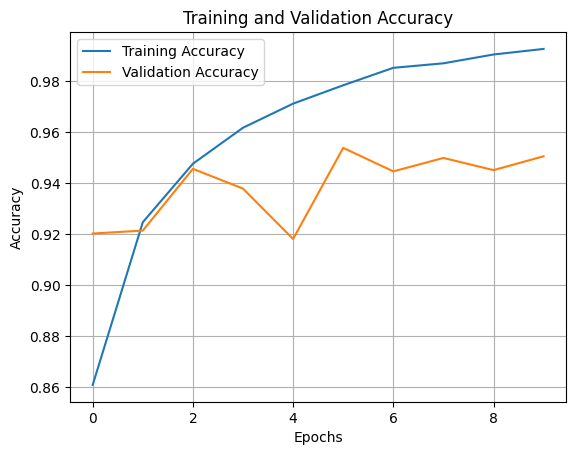

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.evaluate(X_dev, Y_dev)

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9483 - binary_crossentropy: 0.1537 - loss: 0.1537


[0.14188748598098755, 0.9538334608078003, 0.14188748598098755]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
# Get model predictions
Y_pred_probs = model.predict(X_dev)  # Predict probabilities
Y_pred = (Y_pred_probs > 0.5).astype(int)  # Convert to binary labels (0 or 1)


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [16]:
print("Classification Report:")
print(classification_report(Y_dev, Y_pred, target_names=['Machine Generared', 'Human Generated']))


Classification Report:
                   precision    recall  f1-score   support

Machine Generared       0.96      0.95      0.95      3032
  Human Generated       0.95      0.96      0.95      3033

         accuracy                           0.95      6065
        macro avg       0.95      0.95      0.95      6065
     weighted avg       0.95      0.95      0.95      6065



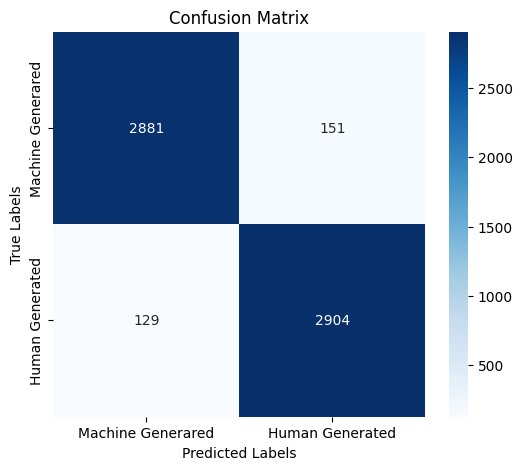

In [17]:
# Compute confusion matrix
cm = confusion_matrix(Y_dev, Y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Machine Generared', 'Human Generated'], yticklabels=['Machine Generared', 'Human Generated'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
model.save("Review Detector.h5")